In [2]:
# !pip install matplotlib tensorflow pandas numpy

In [ ]:
import os
import glob

def get_all_tensorboard_event_files(base_dir):
    """
    Recursively search for all TensorBoard event files in the specified directory structure:
    train_per_row_final_only/row_*/<algo>/tensorboard/<run_name>/events.out.tfevents.*

    Args:
        base_dir (str): Base directory to search.

    Returns:
        List[str]: List of full paths to TensorBoard event files.
    """
    # Pattern: row_*/<algo>/tensorboard/*/events.out.tfevents.*
    pattern = os.path.join(base_dir, "row_*", "*", "tensorboard", "*", "events.out.tfevents.*")
    event_files = glob.glob(pattern, recursive=True)
    return event_files


base_dir = "./train_per_row_final_only_granular_reward"
event_files = get_all_tensorboard_event_files(base_dir)

print(f"🔍 Found {len(event_files)} TensorBoard event files:")
# for file in event_files:
    # print(file)


In [3]:
from tensorflow.python.summary.summary_iterator import summary_iterator

def print_available_tags(event_path):
    tags = set()
    for e in summary_iterator(event_path):
        for v in e.summary.value:
            tags.add(v.tag)
    print(f"Tags found in {event_path}:\n", sorted(tags))

# Example usage
print_available_tags(event_files[0])


Tags found in ./train_per_row_final_only_granular_reward/row_45/ppo/tensorboard/ppo_row_45_1/events.out.tfevents.1748814905.terumo.2528097.0:
 ['rollout/ep_len_mean', 'rollout/ep_rew_mean', 'time/fps', 'train/approx_kl', 'train/clip_fraction', 'train/clip_range', 'train/entropy_loss', 'train/explained_variance', 'train/learning_rate', 'train/loss', 'train/policy_gradient_loss', 'train/value_loss']


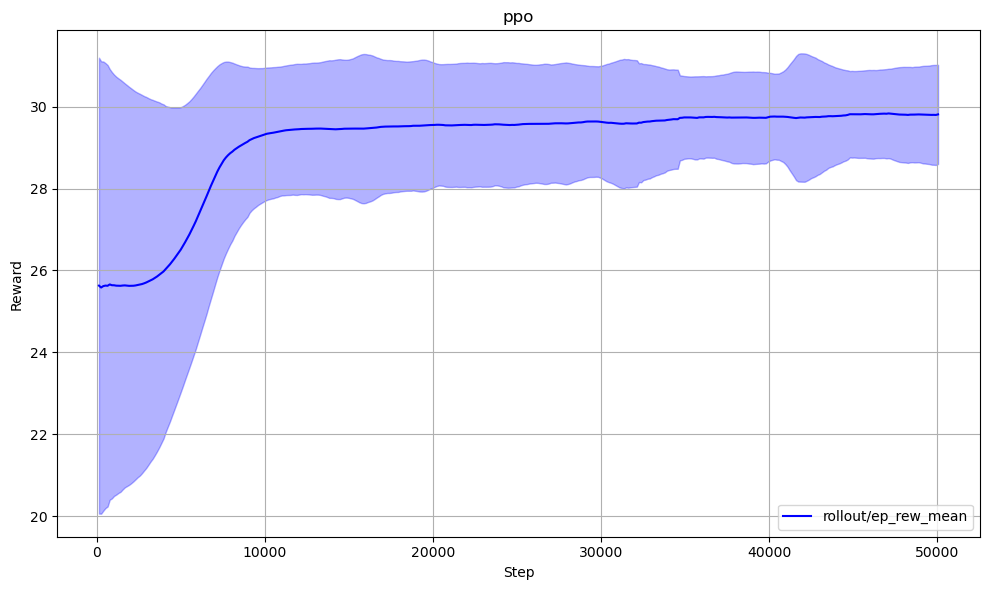

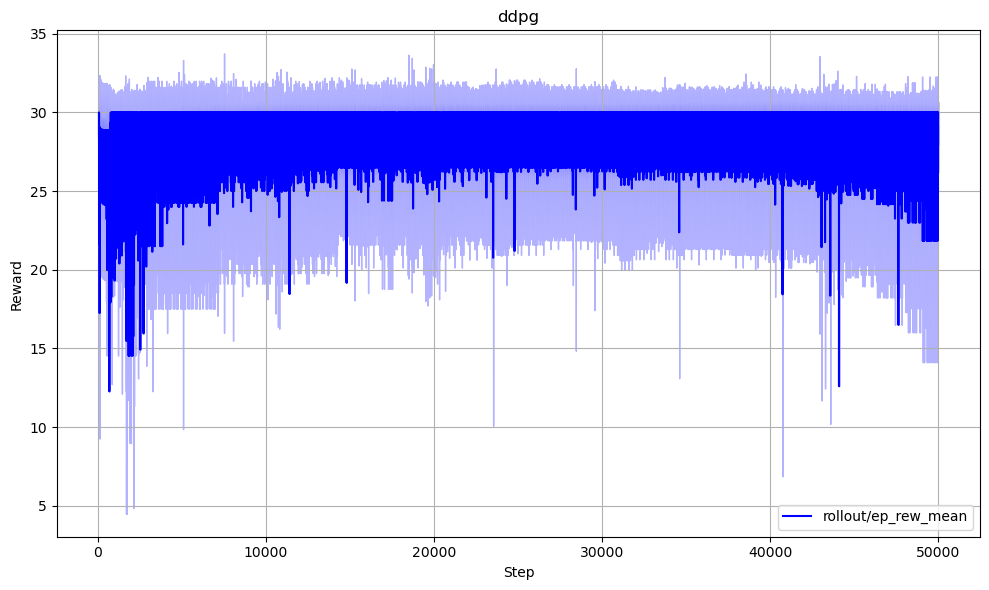

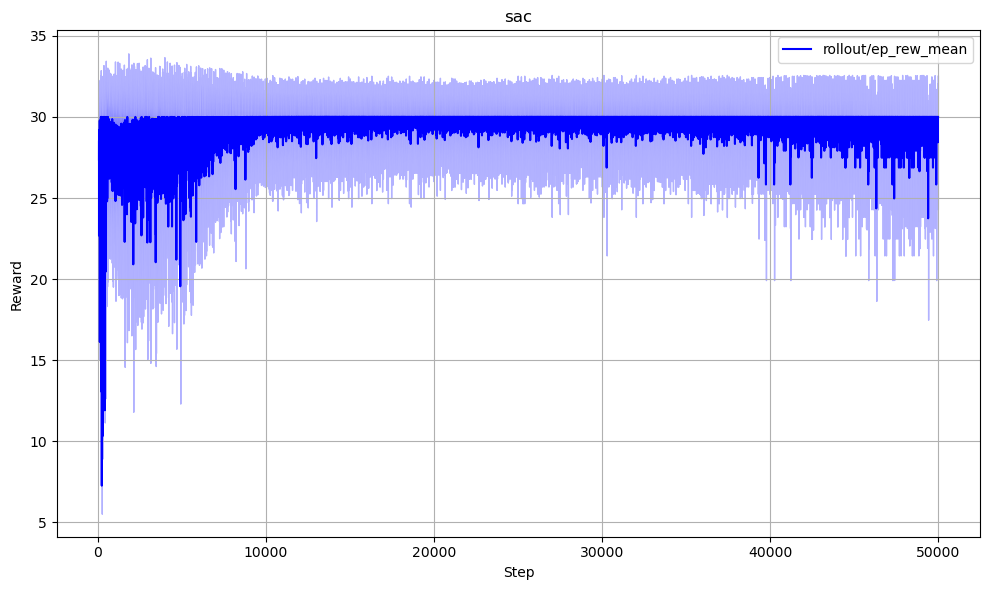

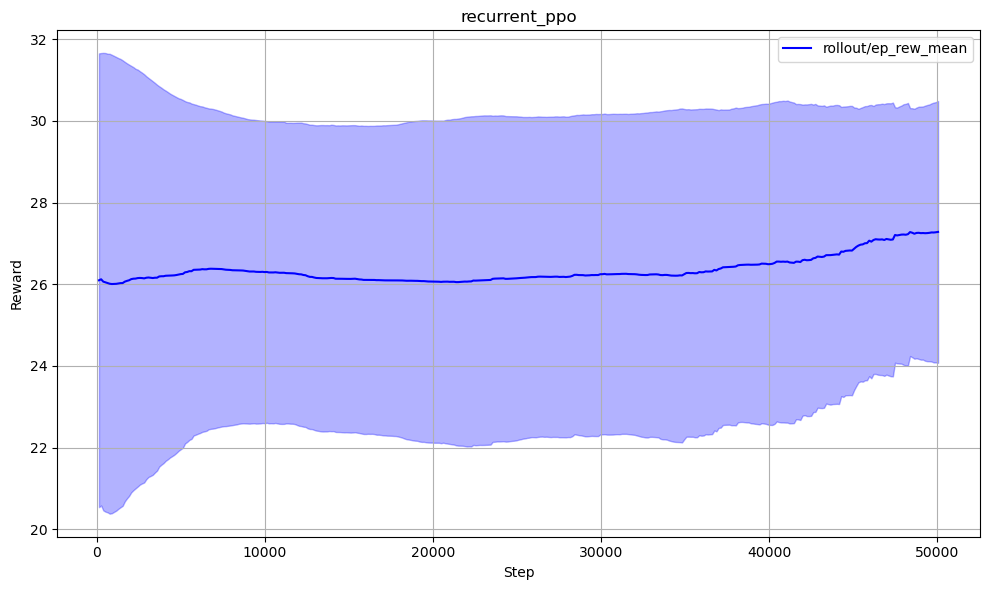

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.python.summary.summary_iterator import summary_iterator
from collections import defaultdict
import re

def extract_rewards(event_paths, tag="rollout/ep_rew_mean"):
    step_data = defaultdict(list)

    for path in event_paths:
        run_data = {}
        for e in summary_iterator(path):
            for v in e.summary.value:
                if v.tag == tag:
                    run_data[e.step] = v.simple_value
        for step, reward in run_data.items():
            step_data[step].append(reward)

    steps = sorted(step_data.keys())
    means = [np.mean(step_data[step]) for step in steps]
    stds = [np.std(step_data[step]) for step in steps]

    return steps, means, stds

def plot_fill_between(steps, means, stds, label="Reward", algo_name=""):
    plt.figure(figsize=(10, 6))
    means = np.array(means)
    stds = np.array(stds)

    plt.plot(steps, means, label=label, color="blue")
    plt.fill_between(steps, means - stds, means + stds, alpha=0.3, color="blue")

    plt.xlabel("Step")
    plt.ylabel("Reward")
    plt.title(f"{algo_name}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def group_by_algorithm(event_paths):
    algo_groups = defaultdict(list)
    for path in event_paths:
        match = re.search(r"/([^/]+)/tensorboard/", path)
        if match:
            algo = match.group(1)
            algo_groups[algo].append(path)
    return algo_groups


# Group files by algorithm
algo_groups = group_by_algorithm(event_files)

# Plot one chart per algorithm
for algo, paths in algo_groups.items():
    steps, means, stds = extract_rewards(paths, tag="rollout/ep_rew_mean")
    if steps:  # Make sure data exists
        plot_fill_between(steps, means, stds, label="rollout/ep_rew_mean", algo_name=algo)


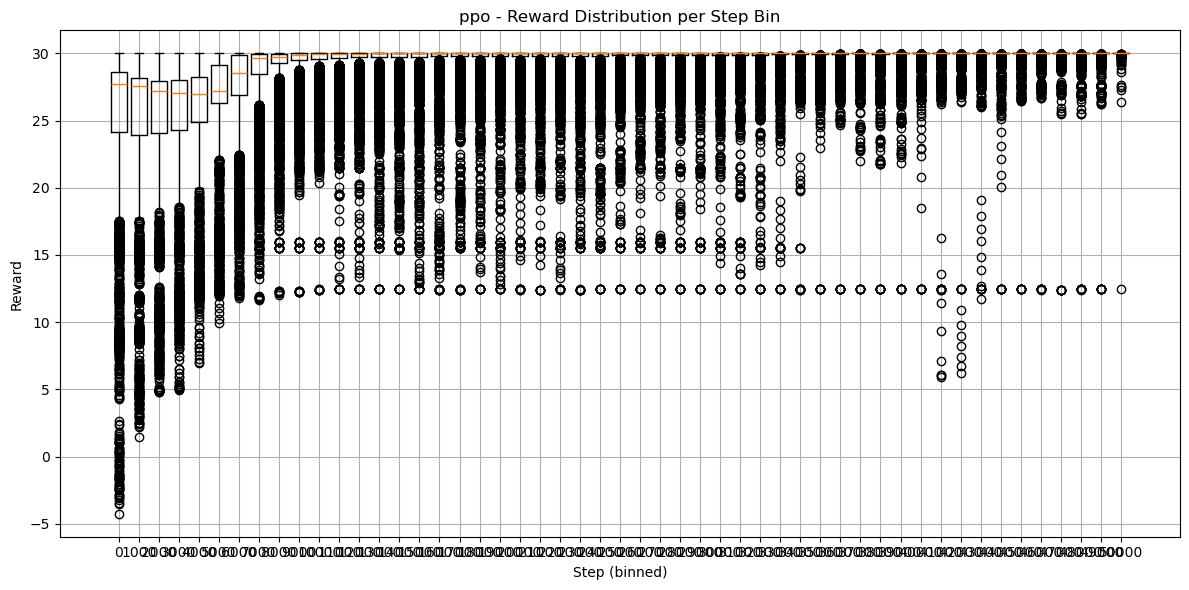

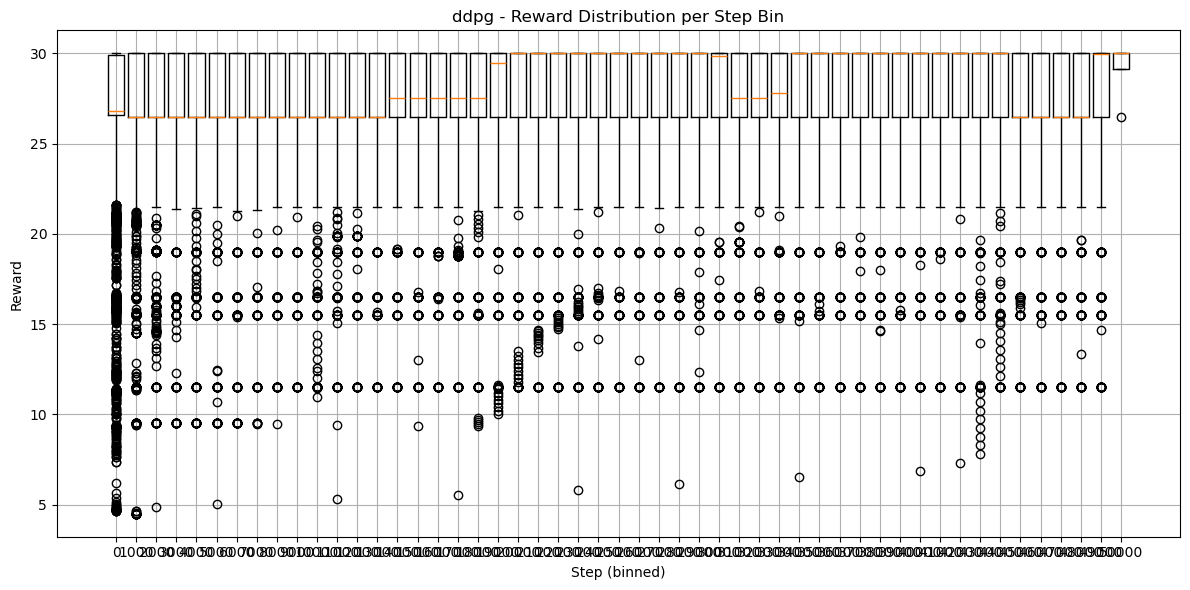

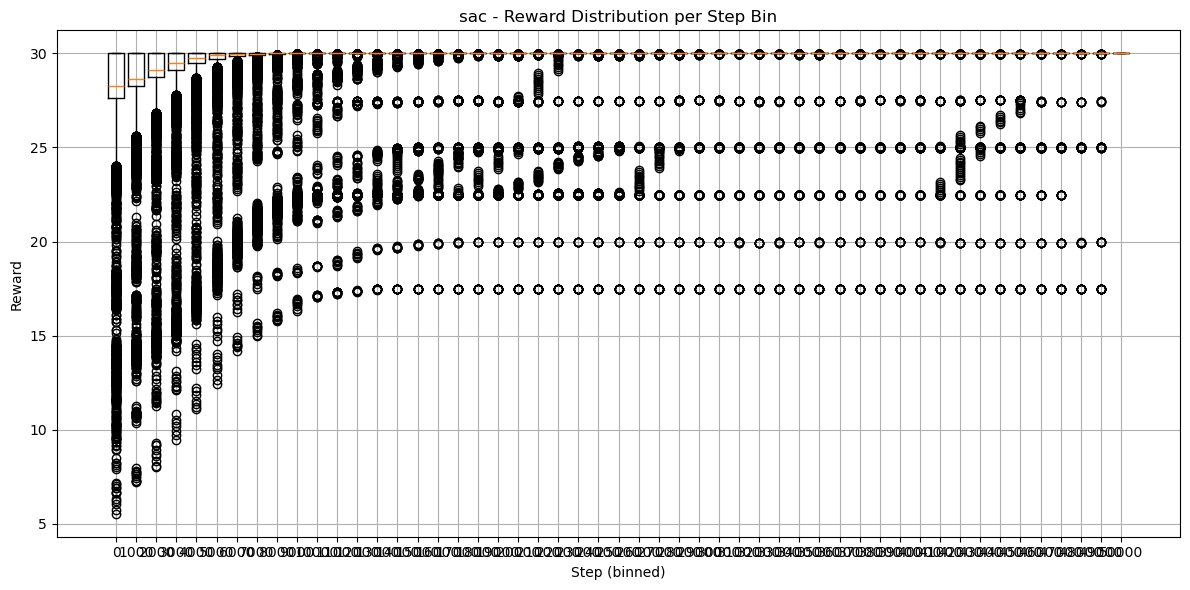

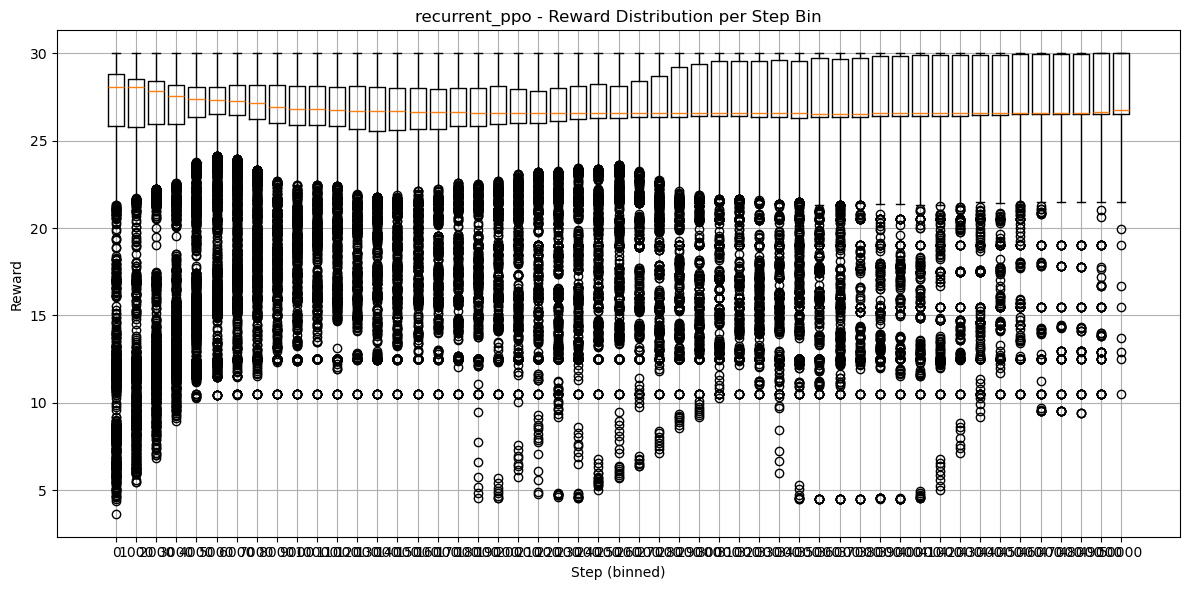

In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.python.summary.summary_iterator import summary_iterator
from collections import defaultdict
import re

def extract_rewards(event_paths, tag="rollout/ep_rew_mean"):
    step_data = defaultdict(list)

    for path in event_paths:
        run_data = {}
        for e in summary_iterator(path):
            for v in e.summary.value:
                if v.tag == tag:
                    run_data[e.step] = v.simple_value
        for step, reward in run_data.items():
            step_data[step].append(reward)

    steps = sorted(step_data.keys())
    means = [np.mean(step_data[step]) for step in steps]
    stds = [np.std(step_data[step]) for step in steps]

    return steps, means, stds

def plot_fill_between(steps, means, stds, label="Reward", algo_name=""):
    plt.figure(figsize=(10, 6))
    means = np.array(means)
    stds = np.array(stds)

    plt.plot(steps, means, label=label, color="blue")
    plt.fill_between(steps, means - stds, means + stds, alpha=0.3, color="blue")

    plt.xlabel("Step")
    plt.ylabel("Reward")
    plt.title(f"{algo_name}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def group_by_algorithm(event_paths):
    algo_groups = defaultdict(list)
    for path in event_paths:
        match = re.search(r"/([^/]+)/tensorboard/", path)
        if match:
            algo = match.group(1)
            algo_groups[algo].append(path)
    return algo_groups

def plot_error_bars(steps, means, stds, label="Reward", algo_name=""):
    plt.figure(figsize=(10, 6))
    means = np.array(means)
    stds = np.array(stds)

    plt.errorbar(steps, means, yerr=stds, fmt='-o', capsize=3, label=label, color="green")

    plt.xlabel("Step")
    plt.ylabel("Reward")
    plt.title(f"{algo_name} - Reward with Error Bars")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
from scipy.ndimage import gaussian_filter1d

def plot_smoothed_line(steps, means, stds, label="Reward", algo_name=""):
    plt.figure(figsize=(10, 6))
    means = np.array(means)
    stds = np.array(stds)

    smoothed_means = gaussian_filter1d(means, sigma=3)
    smoothed_stds = gaussian_filter1d(stds, sigma=3)

    plt.plot(steps, smoothed_means, label=label, color="orange")
    plt.fill_between(steps, smoothed_means - smoothed_stds, smoothed_means + smoothed_stds, alpha=0.2, color="orange")

    plt.xlabel("Step")
    plt.ylabel("Reward")
    plt.title(f"{algo_name} - Smoothed Reward with Std Deviation")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_boxplot_binned(event_paths, tag="rollout/ep_rew_mean", bin_size=1000, algo_name=""):
    import matplotlib.pyplot as plt
    from collections import defaultdict

    all_step_rewards = defaultdict(list)

    for path in event_paths:
        for e in summary_iterator(path):
            for v in e.summary.value:
                if v.tag == tag:
                    bin_key = (e.step // bin_size) * bin_size
                    all_step_rewards[bin_key].append(v.simple_value)

    bins = sorted(all_step_rewards.keys())
    data = [all_step_rewards[b] for b in bins]

    plt.figure(figsize=(12, 6))
    plt.boxplot(data, positions=bins, widths=bin_size*0.8)
    plt.xlabel("Step (binned)")
    plt.ylabel("Reward")
    plt.title(f"{algo_name} - Reward Distribution per Step Bin")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

for algo, paths in algo_groups.items():
    steps, means, stds = extract_rewards(paths, tag="rollout/ep_rew_mean")
    if steps:
        # plot_error_bars(steps, means, stds, label="rollout/ep_rew_mean", algo_name=algo)
        # plot_smoothed_line(steps, means, stds, label="rollout/ep_rew_mean", algo_name=algo)
        plot_boxplot_binned(paths, tag="rollout/ep_rew_mean", bin_size=1000, algo_name=algo)

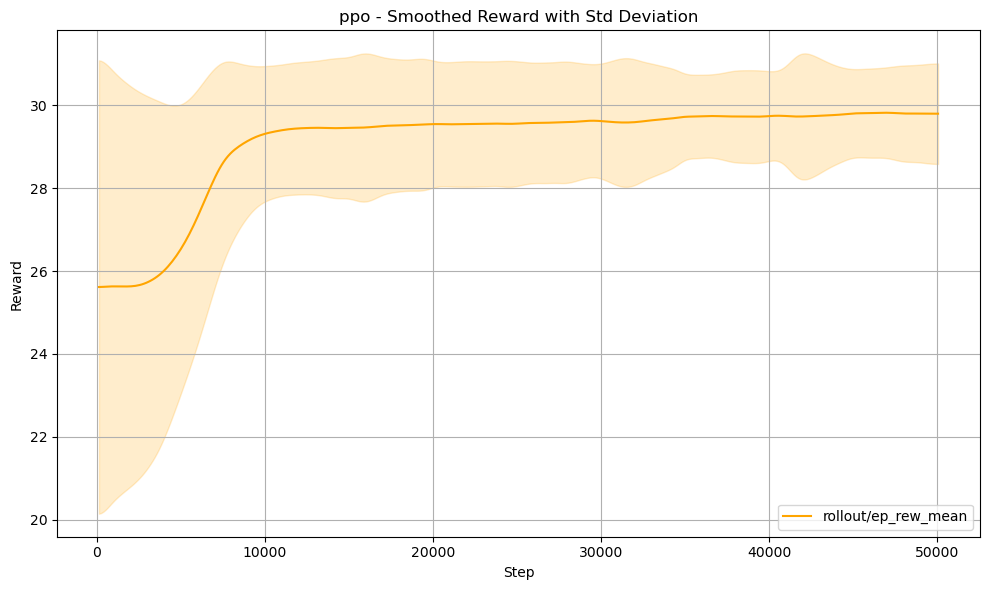

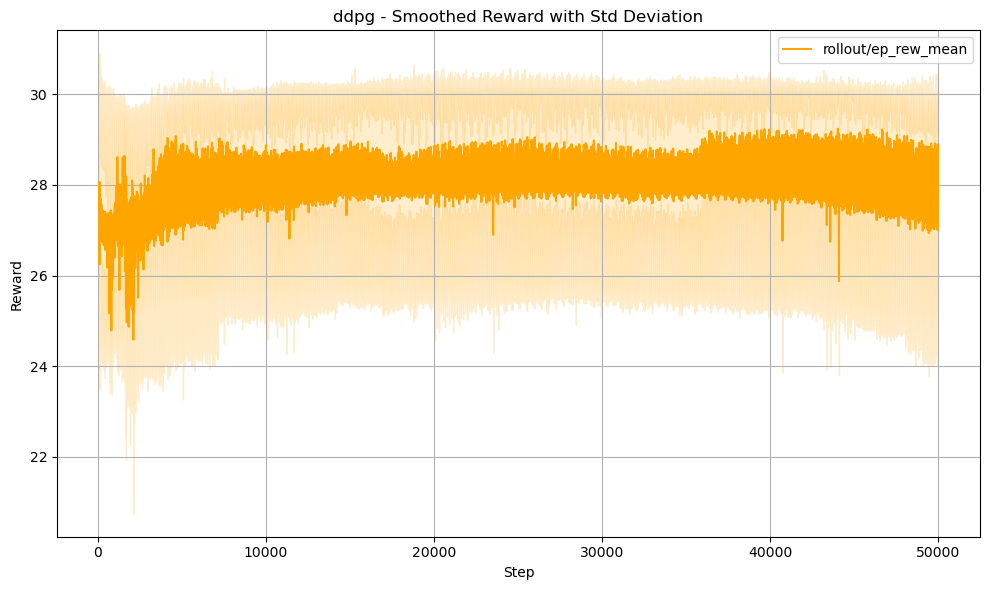

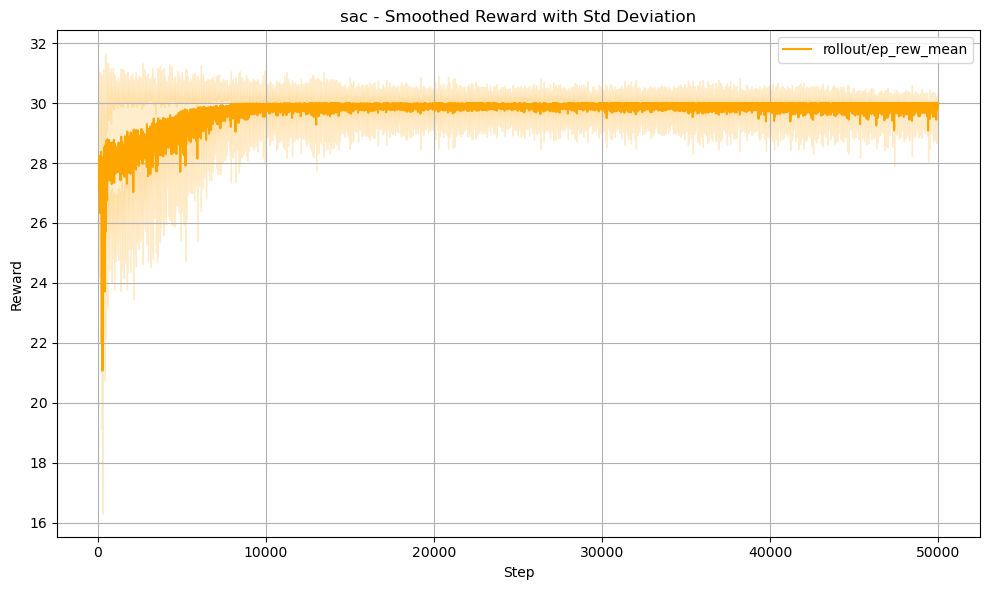

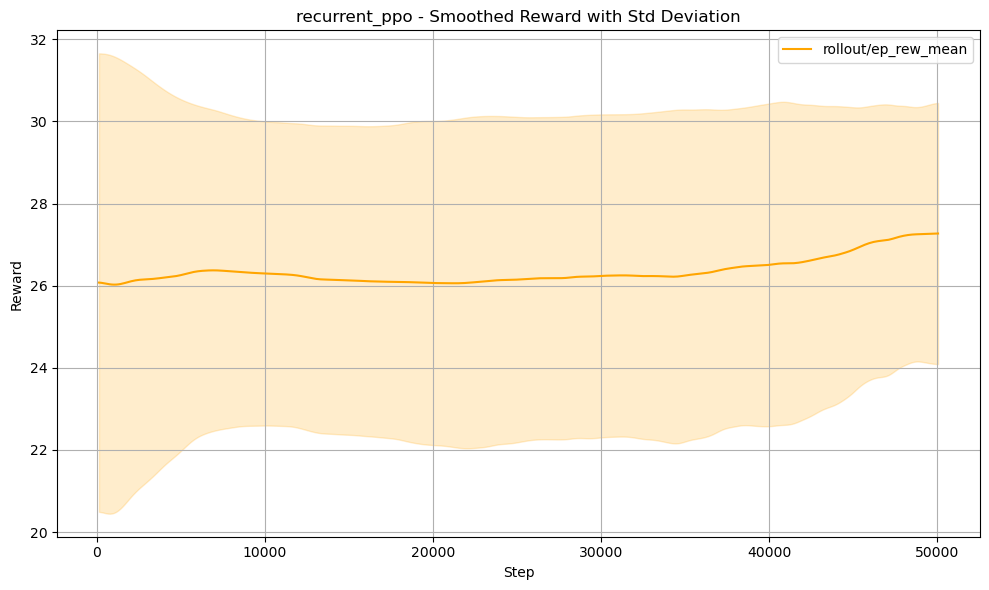

In [18]:

def plot_smoothed_line(steps, means, stds, label="Reward", algo_name=""):
    plt.figure(figsize=(10, 6))
    means = np.array(means)
    stds = np.array(stds)

    smoothed_means = gaussian_filter1d(means, sigma=3)
    smoothed_stds = gaussian_filter1d(stds, sigma=3)

    plt.plot(steps, smoothed_means, label=label, color="orange")
    plt.fill_between(steps, smoothed_means - smoothed_stds, smoothed_means + smoothed_stds, alpha=0.2, color="orange")

    plt.xlabel("Step")
    plt.ylabel("Reward")
    plt.title(f"{algo_name} - Smoothed Reward with Std Deviation")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    
for algo, paths in algo_groups.items():
    steps, means, stds = extract_rewards(paths, tag="rollout/ep_rew_mean")
    if steps:
        # plot_error_bars(steps, means, stds, label="rollout/ep_rew_mean", algo_name=algo)
        plot_smoothed_line(steps, means, stds, label="rollout/ep_rew_mean", algo_name=algo)
        # plot_boxplot_binned(paths, tag="rollout/ep_rew_mean", bin_size=1000, algo_name=algo)


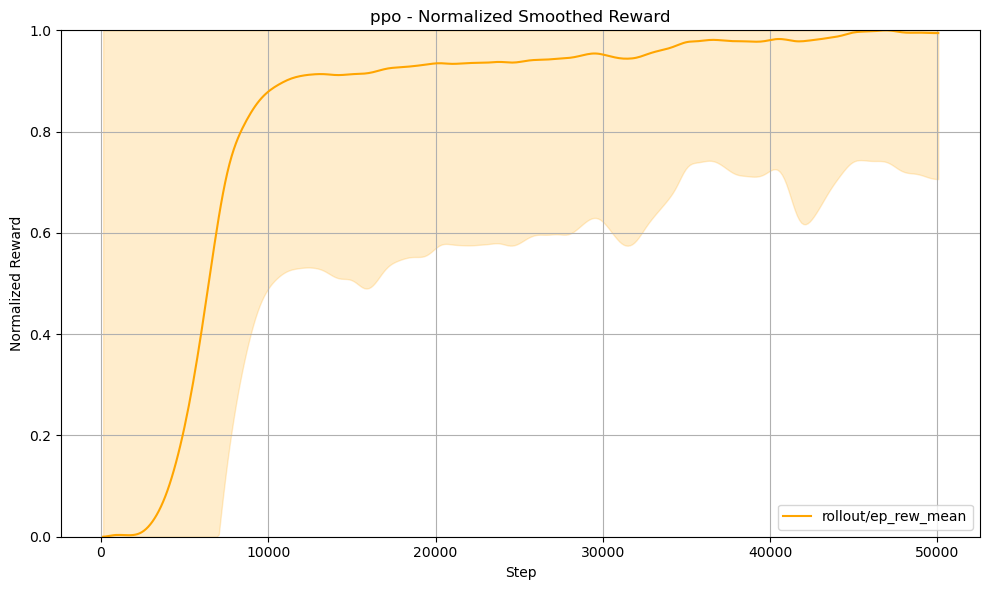

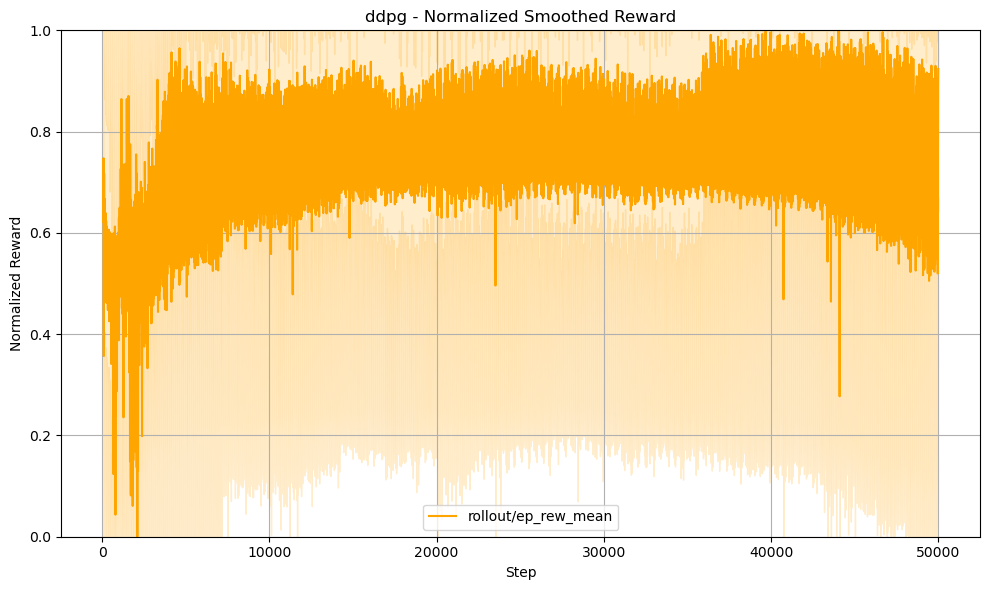

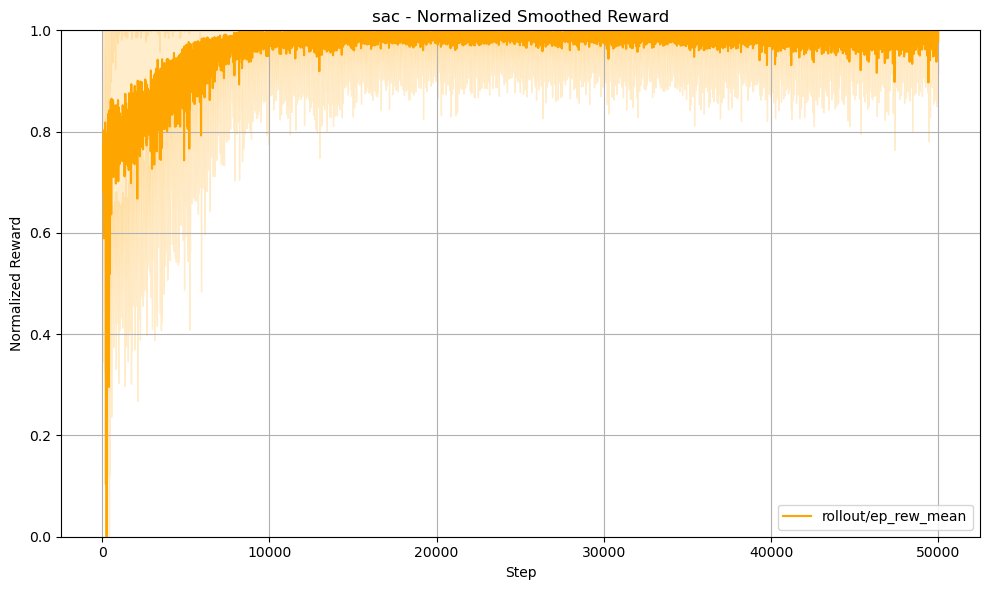

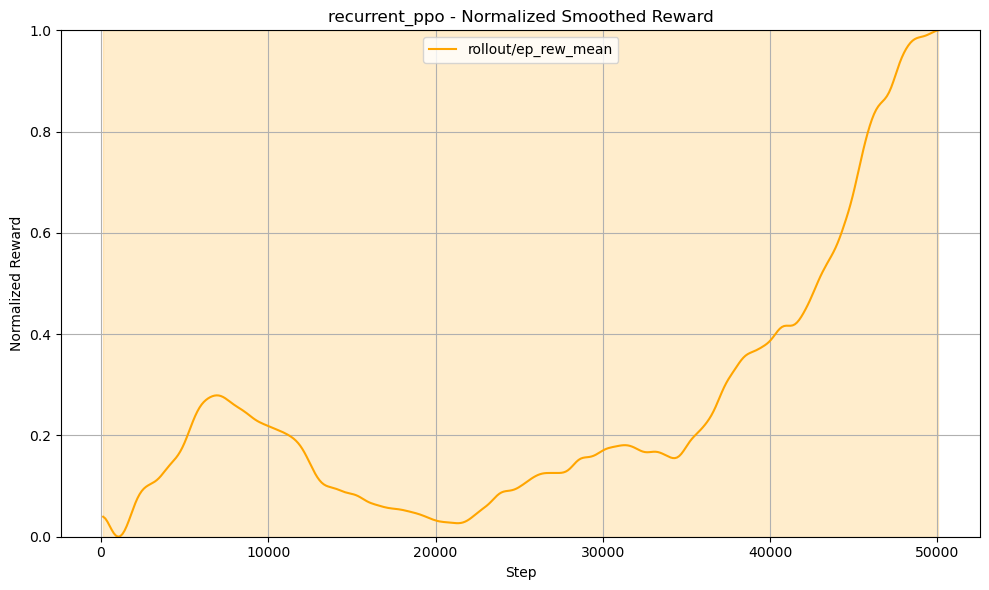

In [19]:
def plot_smoothed_line(steps, means, stds, label="Reward", algo_name=""):
    plt.figure(figsize=(10, 6))
    means = np.array(means)
    stds = np.array(stds)

    smoothed_means = gaussian_filter1d(means, sigma=3)
    smoothed_stds = gaussian_filter1d(stds, sigma=3)

    # Normalize
    min_val = smoothed_means.min()
    max_val = smoothed_means.max()
    range_val = max_val - min_val if max_val > min_val else 1.0
    norm_means = (smoothed_means - min_val) / range_val
    norm_stds = smoothed_stds / range_val

    # Clip fill area to [0, 1]
    lower = np.clip(norm_means - norm_stds, 0, 1)
    upper = np.clip(norm_means + norm_stds, 0, 1)

    plt.plot(steps, norm_means, label=label, color="orange")
    plt.fill_between(steps, lower, upper, alpha=0.2, color="orange")

    plt.xlabel("Step")
    plt.ylabel("Normalized Reward")
    plt.title(f"{algo_name} - Normalized Smoothed Reward")
    plt.ylim(0, 1)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


for algo, paths in algo_groups.items():
    steps, means, stds = extract_rewards(paths, tag="rollout/ep_rew_mean")
    if steps:
        # plot_error_bars(steps, means, stds, label="rollout/ep_rew_mean", algo_name=algo)
        plot_smoothed_line(steps, means, stds, label="rollout/ep_rew_mean", algo_name=algo)
        # plot_boxplot_binned(paths, tag="rollout/ep_rew_mean", bin_size=1000, algo_name=algo)


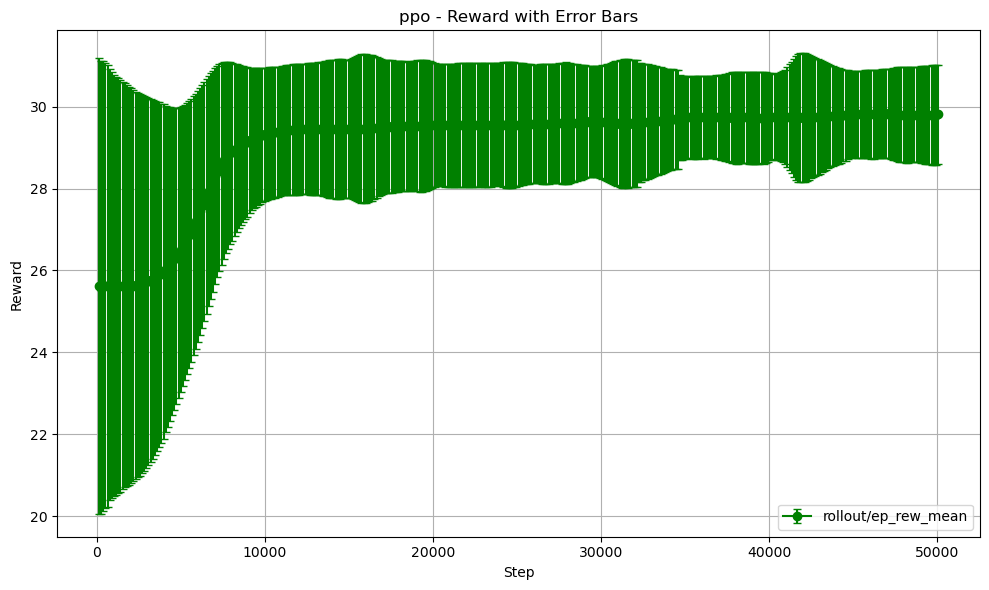

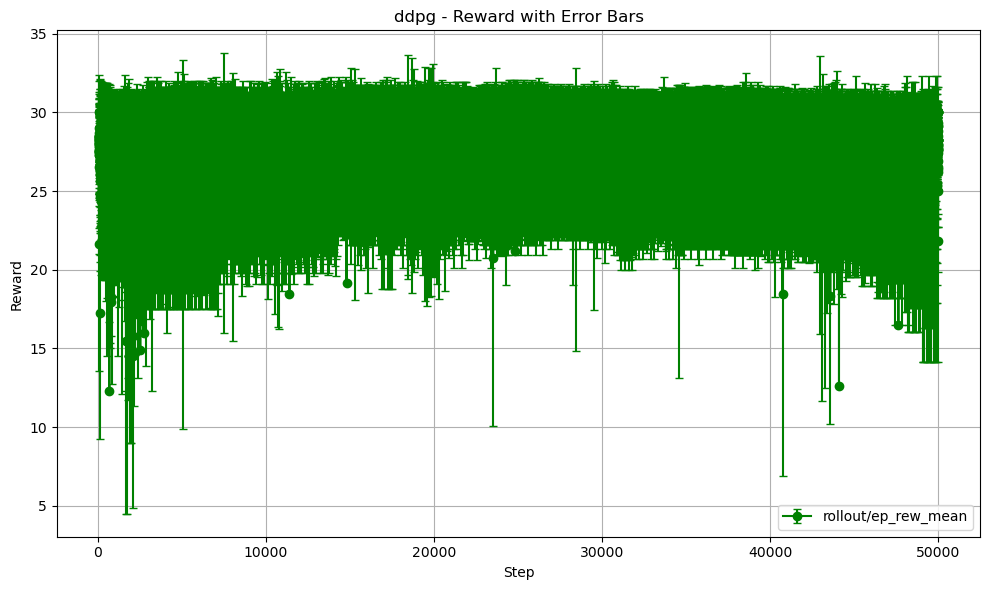

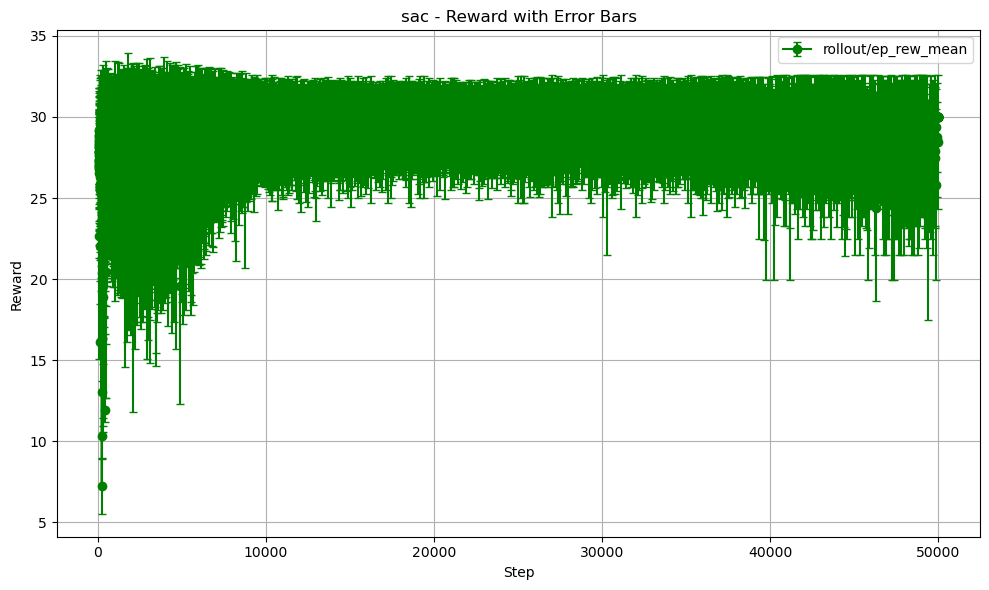

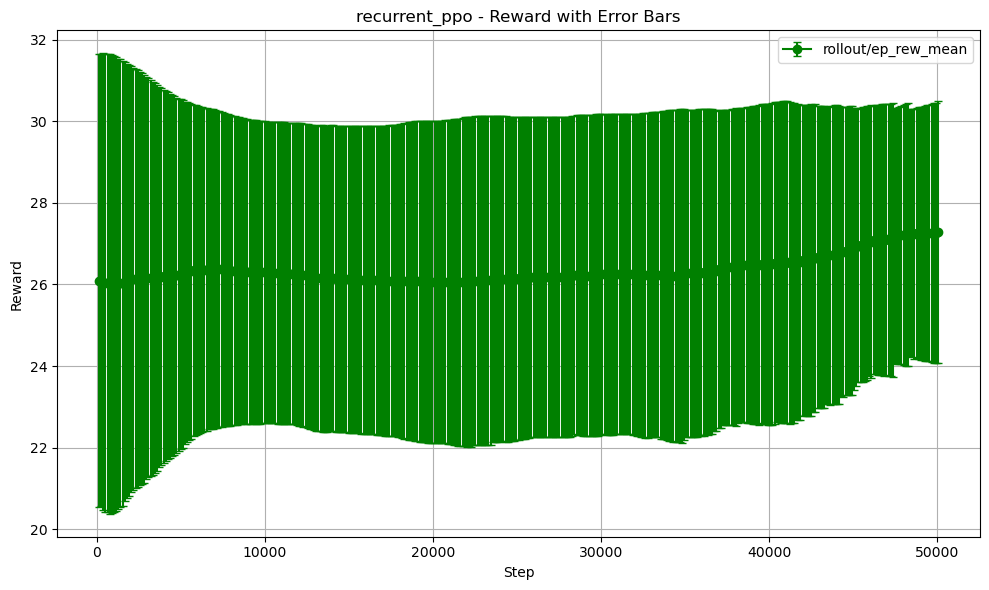

In [7]:

for algo, paths in algo_groups.items():
    steps, means, stds = extract_rewards(paths, tag="rollout/ep_rew_mean")
    if steps:
        plot_error_bars(steps, means, stds, label="rollout/ep_rew_mean", algo_name=algo)
        # plot_smoothed_line(steps, means, stds, label="rollout/ep_rew_mean", algo_name=algo)
        # plot_boxplot_binned(paths, tag="rollout/ep_rew_mean", bin_size=1000, algo_name=algo)
